# Hidden Markov Models with Python

<a href="https://en.wikipedia.org/wiki/Hidden_Markov_model" target="_blank">Hidden Markov Models</a> (HMMs) are a set of widely used statistical models used to model systems which are assumed to follow the <a href="https://en.wikipedia.org/wiki/Markov_chain" target="_blank">Markov process</a>. HMMs have been applied successfully to a wide variety of fields such as <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3407691/" target="_blank">statistical mechanics</a>, <a href="https://www.cs.cornell.edu/courses/cs4758/2012sp/materials/hmm_paper_rabiner.pdf" target="_blank">speech recognition</a> and <a href="https://www.cs.cmu.edu/~bdhingra/papers/stock_hmm.pdf" target="_blank">stock market predictions</a>. Although HMMs have been replaced by deep neural networks in several areas of application such as speech recognition and stock market predictions, understanding how they work might allow us to better appreciate why more advanced models work in a particular way for a given dataset.

## How Hidden Markov Models Work

In HMMs, we have a set of observed states __X__ which are generated by a corresponding set of hidden unobservable states __Z__. The HMMs themselves are defined by the following 3 model parameters:

1. Initial state probabilities __𝝅__. This is given by `model.startprob_` in `hmmlearn`.

2. Hidden state transition probabilities _A_. This is given by `model.transmat_` in `hmmlearn`.

3. Observable emission probabilities __𝜽__. This depends on the type of HMM, but for Gaussian emissions in `hmmlearn` this is given by `model.means_` and `model.covars_` which contain the mean and covariances for the Gaussian distribution.

## Three Classes of Problems for HMMs

Generally speaking, the three typical problems encountered in HMMs are as follows:

1. Given a set of observed states __X__ and the 3 model parameters __𝝅__, __A__ and __𝜽__, calculate the probability of the observed states __X__ occurring.

2. Given a set of observed states __X__ and the 3 model parameters __𝝅__, __A__ and __𝜽__, determine the optimal set of hidden states __Z__ that give rise to __X__.

3. Given only a set of observed states __X__, determine the optimal set of model parameters __𝝅__, __A__ and __𝜽__.

## HMMs in Python

In this post, we will be looking at problem 3 using historical gold prices downloaded from https://www.gold.org/goldhub/data/gold-prices. We will be using the `hmmlearn` library which provides HMM functionality in python. 

We import the necessary libraries as well as the data into python, and plot the historical data. We also calculate the daily change in gold price and restrict the data from 2008 onwards (Lehmann shock and Covid19!). In general dealing with the change in price rather than the actual price itself leads to better modeling of the actual market conditions.

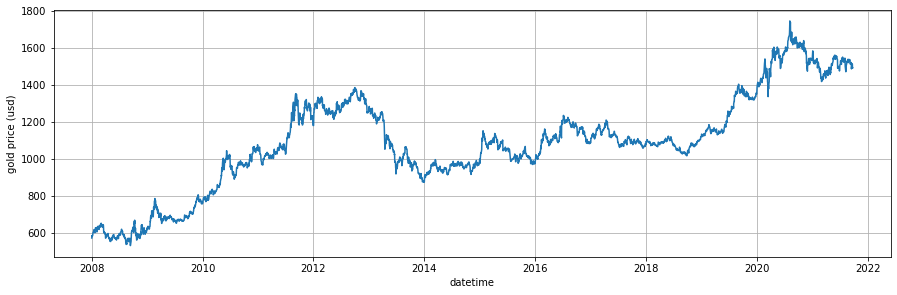

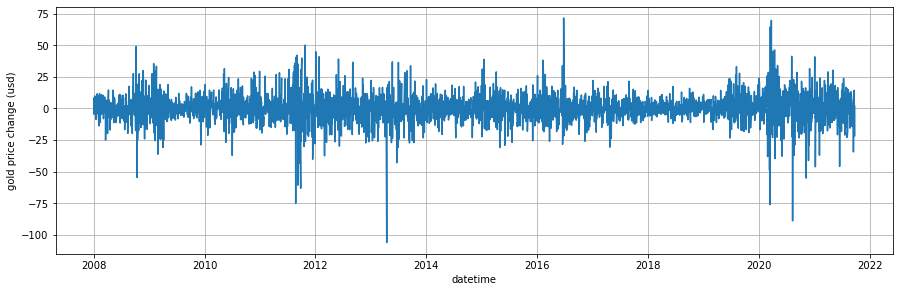

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

base_dir = "https://github.com/natsunoyuki/Data_Science/blob/master/gold/gold/gold_price_usd.csv?raw=True"
data = pd.read_csv(base_dir)
data["datetime"] = pd.to_datetime(data["datetime"])
data["gold_price_change"] = data["gold_price_usd"].diff()
data = data[data["datetime"] >= pd.to_datetime("2008-01-01")]

plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.plot(data["datetime"], data["gold_price_usd"])
plt.xlabel("datetime")
plt.ylabel("gold price (usd)")
plt.grid(True)
plt.figure(figsize = (15, 10))
plt.subplot(2,1,2)
plt.plot(data["datetime"], data["gold_price_change"])
plt.xlabel("datetime")
plt.ylabel("gold price change (usd)")
plt.grid(True)
plt.show()

Using the change in gold price, build a Gaussian emission HMM using `hmmlearn`. We chose the Gaussian emission as it is the most straight forward model and the easiest to interpret. We assume that there are 3 different hidden states in the gold price data corresponding to low volatility, medium volatility and high volatility. This is of course a very simplistic assumption and there are other possible assumptions. We assume that the covariance matrix is full, giving the greatest degrees of freedom to the system. We iterate 50 times during the fitting process. This does not necessarily result in the best model, but works for now as a demonstration.

In [2]:
# Build hidden markov models to model the change in gold price

# Hidden Markov Models
# --------------------
# Inputs
# ------
# X: np.array of observable states
# Outputs
# -------
# Z: np.array of hidden internal states corresponding to X
# Model Parameters
# ----------------
# startprob_: np.array of start probabilities
# transmat_: np.array of internal states transition
# means_: np.array of observable emission probability means
# covars_: np.array of observable emission probability covariances

X = data[["gold_price_change"]].values
# Build the HMM model and fit to the gold price change data
model = hmm.GaussianHMM(n_components = 3, covariance_type = "full", n_iter = 50)
model.fit(X)
# Predict the hidden states corresponding to X
Z = model.predict(X)
states = pd.unique(Z)

print("Unique states:")
print(states)
print("Start probabilities:")
print(model.startprob_)
print("Transition matrix:")
print(model.transmat_)
print("Gaussian distribution means:")
print(model.means_)
print("Gaussian distribution covariances:")
print(model.covars_)

Unique states:
[1 0 2]
Start probabilities:
[4.86009979e-24 1.00000000e+00 7.73125025e-47]
Transition matrix:
[[7.01061110e-01 2.46682013e-01 5.22568771e-02]
 [1.45028159e-01 8.54348308e-01 6.23533032e-04]
 [1.61481641e-01 1.27701928e-03 8.37241339e-01]]
Gaussian distribution means:
[[0.21397731]
 [0.2787461 ]
 [0.27533363]]
Gaussian distribution covariances:
[[[143.0056039 ]]

 [[ 33.79735318]]

 [[517.86583798]]]


Fitting the model on the data, we find that the states 0, 1 and 2 correspond to low volatility, medium volatility and high volatility (check the graphs below!). The model determined that the starting state probabilities are [1, 0, 0] which means that the data starts off in the low volatility state. The transition matrix tells us that systems in state 0 have a 52% chance of staying in state 0, and a 48% chance of moving to state 1, while systems in state 2 have a 98% chance of staying in state 2. Therefore generally, the market appears to fluctuate between the low and medium volatility states under "normal" conditions. When the market enters the high volatility state, it tends to remain in that state for a significant period of time before returning to normal.

The Gaussian distribution parameters show that in state 0 the change in gold price has a mean of 0.38 USD with a variance of 37.91 USD, while in state 2 the change in gold price has a mean of -0.36 USD with a variance of 620.11 USD. The extremely large variances indicate that using 3 hidden states might not have captured the emission probabilities precisely. However the variances do support the low volatility, medium volatility and high volatility assumption.

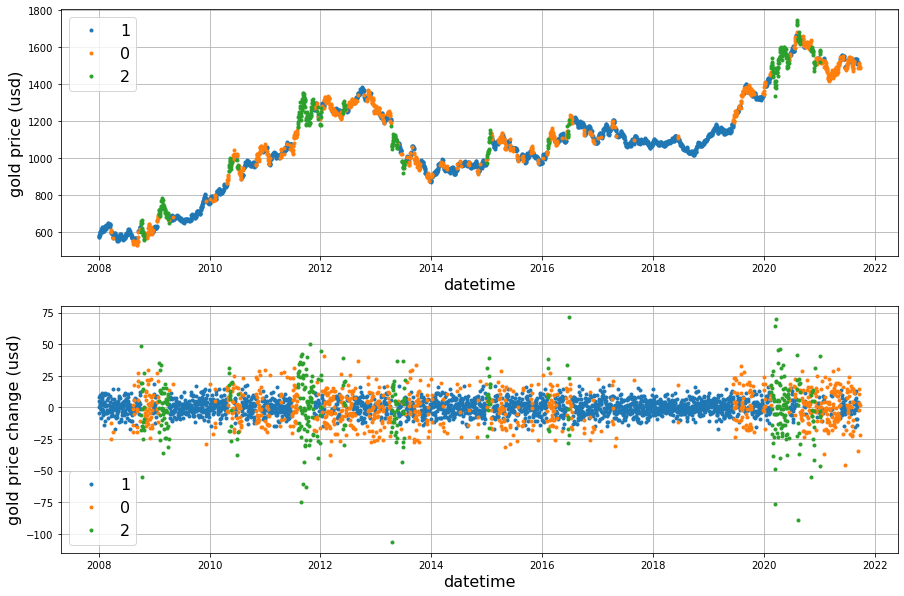

In [3]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_price_usd"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_price_change"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price change (usd)", fontsize=16)
plt.show()

From the graphs, we find that periods of high volatility correspond to periods of difficult economic times such as the Lehmann shock from 2008 to 2009, the recession of 2011-2012 and the covid19 pandemic induced recession in 2020. Furthermore, we see that the price of gold tends to rise during times of uncertainty as investors increase their purchases of gold which is seen as a stable and safe asset.

Unfortunately, although the model was able to give us a good representation of the hidden states, it is too rough to do any meaningful predictions. Instead of training one model on the entire dataset, what should be done to get a more precise model is to split the data into several windows and train one model for each window. For example, one model for each month. This set of localized models should be more precise than the global model which we made in this post.